In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk


In [129]:
# Read in data
df = pd.read_csv('/content/Reviews.csv')
print(df.shape)
df = df.head(3000)
print(df.shape)

(568454, 10)
(3000, 10)


In [130]:
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# #Quick EDA

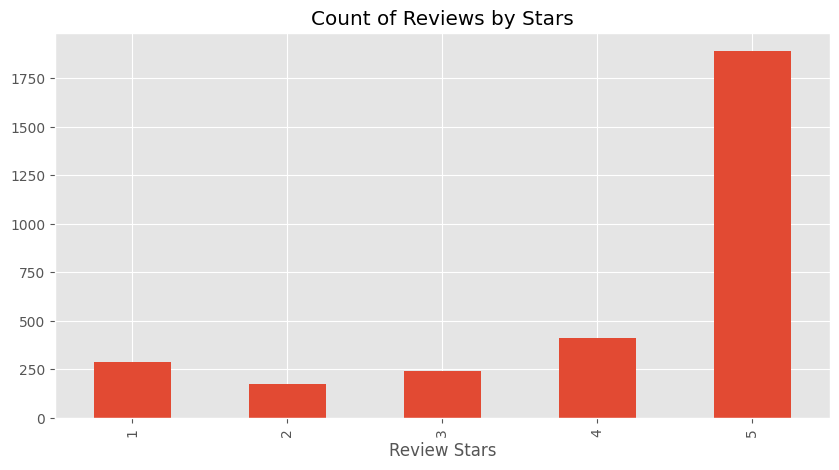

In [131]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# Basic NLTK

In [132]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [133]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [134]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [135]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [136]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [137]:
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!


True

In [138]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [139]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step1
**VADER Seniment Scoring**
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.

In [140]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [141]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [142]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [143]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [144]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [145]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [146]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [147]:
# Now we have sentiment score and metadata
vaders.head()


,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


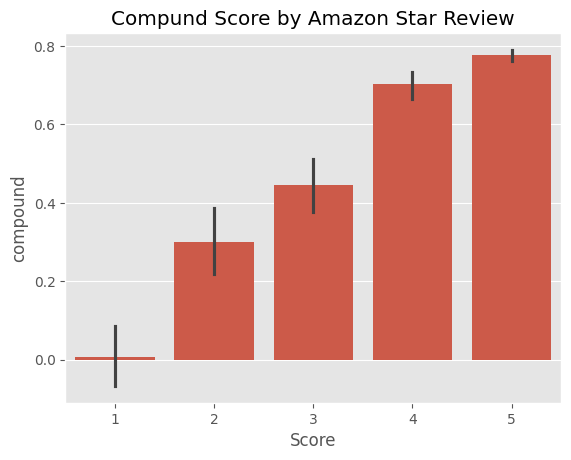

In [148]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

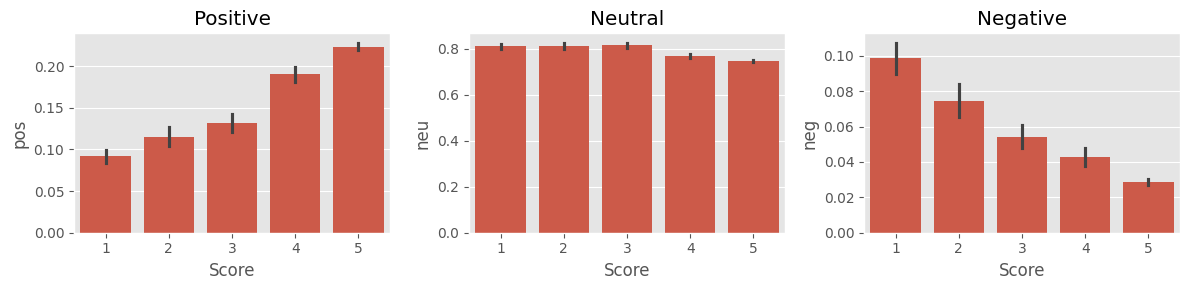

In [149]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [150]:
# Compare VADER results to original Score
vaders['vader_sentiment'] = vaders['compound'].apply(lambda score: 'pos' if score >= 0.05 else ('neg' if score <= -0.05 else 'neu'))

# Map the original Score to sentiment labels
def map_score_to_sentiment(score):
    if score > 3:
        return 'pos'
    elif score < 3:
        return 'neg'
    else:
        return 'neu'

vaders['original_sentiment'] = vaders['Score'].apply(map_score_to_sentiment)

# Calculate accuracy
accuracy = (vaders['vader_sentiment'] == vaders['original_sentiment']).mean()
print(f'Accuracy: {accuracy:.2f}')

# Display the comparison
display(vaders[['Score', 'compound', 'vader_sentiment', 'original_sentiment']].head())

Accuracy: 0.80


,Score,compound,vader_sentiment,original_sentiment
0,5,0.9441,pos,pos
1,1,-0.5664,neg,neg
2,4,0.8265,pos,pos
3,2,0.0000,neu,neg
4,5,0.9468,pos,pos


# Step 1: Prepare the dataNe
We will split the data into training and testing sets and use TF-IDF to vectorize the text.

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert original Score to a binary sentiment (positive or negative) for simplicity
# We'll consider scores > 3 as positive (1) and scores < 3 as negative (0)
# We'll exclude neutral reviews (score = 3) for this binary classification example
df_binary = vaders[vaders['Score'] != 3].copy()
df_binary['sentiment'] = df_binary['Score'].apply(lambda score: 1 if score > 3 else 0)

X = df_binary['Text']
y = df_binary['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000) # You can adjust max_features

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)

print("Data preparation complete.")
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Data preparation complete.
Shape of X_train_tfidf: (1930, 5000)
Shape of X_test_tfidf: (828, 5000)


# Step 2 & 3: Choose and Train a Model
We will use a Naive Bayes classifier to train on the TF-IDF transformed training data.

In [152]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes Classifier
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train_tfidf, y_train)

print("Model training complete.")

Model training complete.


## Step 4: Evaluate the model

We will evaluate the trained model on the testing data.

In [153]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict sentiment on the test data
y_pred = nb_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       132
           1       0.84      1.00      0.91       696

    accuracy                           0.84       828
   macro avg       0.42      0.50      0.46       828
weighted avg       0.71      0.84      0.77       828


Confusion Matrix:
[[  0 132]
 [  0 696]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Exploring Other Models: Logistic Regression

After trying Naive Bayes, let's explore another common model for binary classification: Logistic Regression.

In [157]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression Classifier
lr_model = LogisticRegression(max_iter=3000) # Increased max_iter for convergence

# Train the model
lr_model.fit(X_train_tfidf, y_train)

print("Logistic Regression model training complete.")


Logistic Regression model training complete.


In [155]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict sentiment on the test data
y_pred_lr = lr_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\nLogistic Regression Accuracy: {accuracy_lr:.2f}")

# Display classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Display confusion matrix
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.85

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.08      0.14       132
           1       0.85      1.00      0.92       696

    accuracy                           0.85       828
   macro avg       0.84      0.54      0.53       828
weighted avg       0.85      0.85      0.79       828


Logistic Regression Confusion Matrix:
[[ 10 122]
 [  2 694]]


#Will ADD Later
# Roberta Pretrained Model
Use a model trained of a large corpus of data.
Transformer model accounts for the words but also the context related to other words.
